In [16]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram, plot_distribution
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from dotenv import load_dotenv
import os

In [4]:
def build_oracle(qc, gates):
    """
    Append gates to the given quantum circuit.
    """
    for gate_name, gate_target in gates:
        gate = getattr(qc, gate_name)
        gate(*gate_target)


In [5]:
def phase_oracle(n, gates_to_apply, name="oracle"):
    qc = QuantumCircuit(n, name=name)
    build_oracle(qc, gates_to_apply)
    return qc

In [6]:
def diffuser(n, gates_to_apply, name="diffuser"):
    qc = QuantumCircuit(n, name=name)

    for qb in range(n - 2):
        qc.h(qb)
    for i in range(n - 2):
        qc.x(i)

    build_oracle(qc, gates_to_apply)

    for i in range(n - 2):
        qc.x(i)
    for qb in range(n - 2):
        qc.h(qb)
    return qc

In [7]:
def grover_algorithm(grover_bits, gates_steps):
    # In the given example, there are three qubit programs,
    # the fourth qubit is the zero qubit reference and fifth one 
    # is to insert the ancilla qubit minus state
    n = grover_bits
    gr = QuantumCircuit(n, n - 2)

    # Number of solutions
    #mu = solutions
    #iterations = int(np.floor(np.pi / 4 * np.sqrt(2 ** (n - 2)) / mu))

    iterations = int(np.pi/4 * np.sqrt(2**(n - 2)))

    print(f'Oracle and diffuser applied {iterations} time(s)')

    # Step 1: apply Hadamard gates on all working qubits
    gr.h(range(n - 2)) 

    # Put ancilla in minus state |->
    gr.x(n - 1)
    gr.h(n - 1)

    # Step 2: apply r rounds of the phase oracle and the diffuser
    for r in range(iterations):
        gr.append(phase_oracle(n, gates_steps), range(n))
        gr.append(diffuser(n, gates_steps), range(n))

    gr.measure(range(n - 2), range(n - 2))

    return gr


In [8]:
def transpile_circuit(grover_circuit):
    
    display(grover_circuit.draw(output='mpl'))
    
    simulator = AerSimulator()
    transpiled_qc = transpile(grover_circuit, simulator)
    job = simulator.run(transpiled_qc, shots=1000)  # Aumentamos el número de shots
    result = job.result()
    counts = result.get_counts()
    
    print("Counts:", counts)
    display(plot_histogram(counts))

In [14]:
def transpile_circuit_quantum(grover_circuit):
    load_dotenv(dotenv_path="../.env")
    ibm_token = os.getenv("IBM_TOKEN")

    QiskitRuntimeService.save_account(channel="ibm_quantum",
								  token=ibm_token, overwrite=True,
								  set_as_default=True)
    service = QiskitRuntimeService()
    backend = service.least_busy(operational=True, simulator=False)
    print(f"Using backend: {backend.name}")

    target = backend.target
    pass_manager = generate_preset_pass_manager(target=target, optimization_level=2, backend=backend)
    transpiled = pass_manager.run(grover_circuit)

    transpiled.draw("mpl", idle_wires=False, style="iqp")

    sampler = Sampler(mode=backend)

    sampler.options.dynamical_decoupling.enable = True
    sampler.options.twirling.enable_gates = True
    
    job = sampler.run([transpiled], shots=500)
    job_id = job.job_id()
    print(job_id)

    result = job.result()

    dist = result[0].data.meas.get_counts()
    print(dist)
    plot_distribution(dist, title="Quantum results for Entanglement (in %)")

Oracle and diffuser applied 2 time(s)


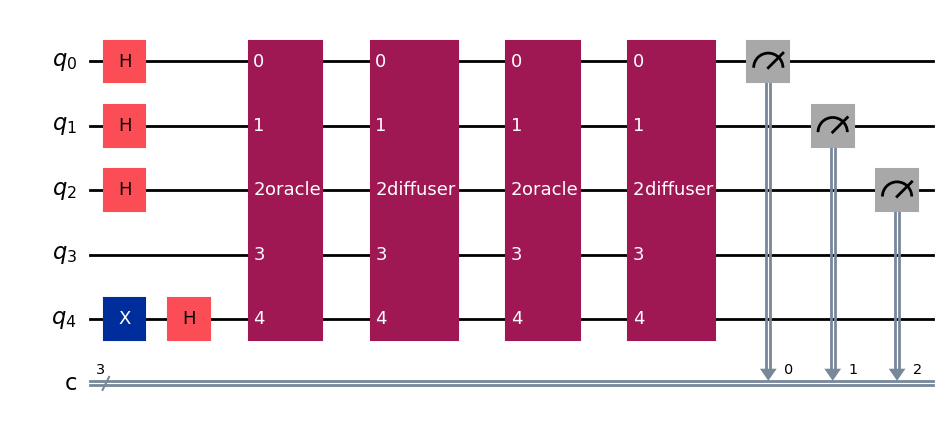

Counts: {'110': 9, '001': 6, '101': 12, '100': 9, '000': 8, '010': 9, '011': 9, '111': 938}


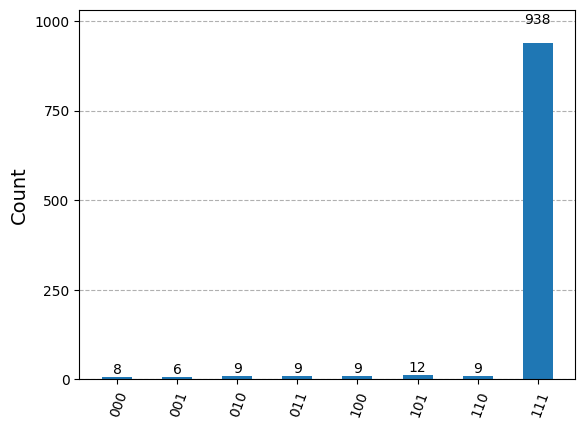

In [11]:
gates = [
    ("h", [2]),
    ("ccx", [0, 1, 2]),
    ("h", [2]),
]
'''
qc.ccx(0, 1, 2)
- Toffoli gate (CCX) in qubits 0, 1, and 2:
- CCX controled controled NOT gate.
- Inverts qubit 2 only if qubits 0 and 1 are in |1⟩

- After H - CCX - H the state of the sitem is:
a|000⟩ + b|001⟩ + c|010⟩ + d|011⟩ + e|100⟩ + f|101⟩ + g|110⟩ - h|111⟩
'''

nqubits = 3
nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates)


gr = grover_algorithm(nqubitsctrl, gates)

transpile_circuit(gr)

In [ ]:
gates = [
    ("h", [2]),
    ("ccx", [0, 1, 2]),
    ("h", [2]),
]

nqubits = 3
nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates)


gr = grover_algorithm(nqubitsctrl, gates)

transpile_circuit_quantum(gr)

Oracle and diffuser applied 2 time(s)
Using backend: ibm_sherbrooke
cvsg00gy6y80008bjqd0


Oracle and diffuser applied 1 time(s)


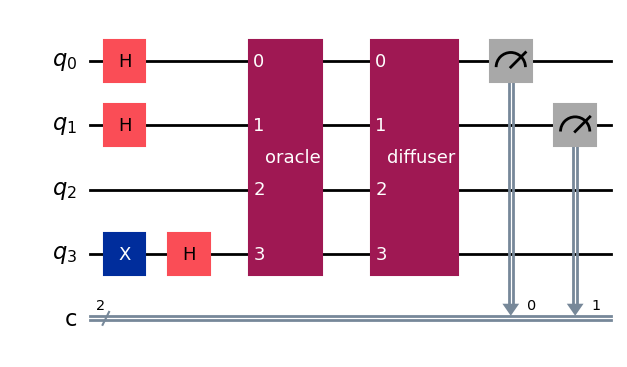

Counts: {'01': 1000}


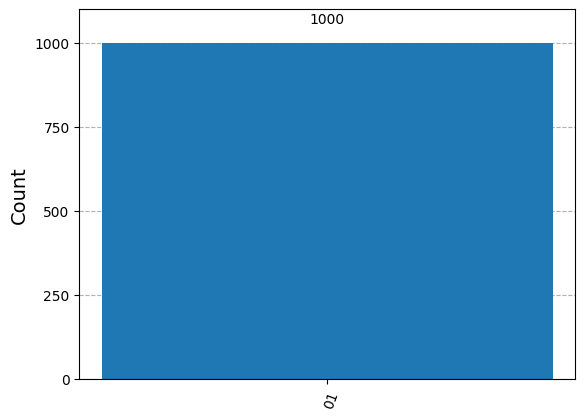

In [12]:
gates = [
    ("ry", [np.pi/2, 1]),
    ("cx", [0, 1]),
    ("ry", [-np.pi/2, 1]),
    ("cx", [0, 1]),
]

'''
|00⟩ → |00⟩
|01⟩ → -|01⟩ (phase change)
|10⟩ → |10⟩
|11⟩ → |11⟩
'''

nqubits = 2
nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates)

gr = grover_algorithm(nqubitsctrl, gates)

transpile_circuit(gr)

Oracle and diffuser applied 2 time(s)
Using backend: ibm_sherbrooke
cvsf09sg7h200081aw30
Counts: [{'01': 500}]


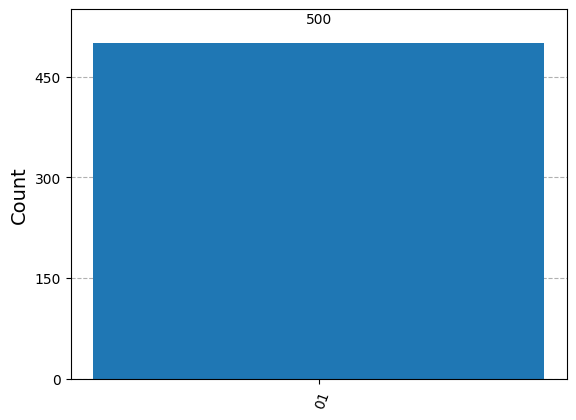

In [131]:
gates = [
    ("h", [2]),
    ("ccx", [0, 1, 2]),
    ("h", [2]),
]

nqubits = 3
nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates_to_apply)

gr = grover_algorithm(nqubitsctrl, gates)

transpile_circuit_quantum(gr)

In [ ]:
gates = [
    ("ch", [0, 2]),
    ("ccx", [1, 3, 2]),
    ("ch", [0, 2]),
]

ORACLE_BITS = 5
GROVER_BITS = ORACLE_BITS + 2
oracle = QuantumCircuit(GROVER_BITS)
build_oracle(oracle, gates)

gr = grover_algorithm(nqubitsctrl, gates)

transpile_circuit(gr)